# Finding the Essential matrix between 2 images. Then use it to perform 3d reconstruction

1. Load images, find and match key points, filter out bad matches (Lowe)
2. Use good matches to determine Essential Matrix
3. Use essential matrix, good points, and calibration matrix to recover the pose (rotation and unit translation) of the 2nd camera relative to the first
4. Rectify both images using the pose and calibration parameters of both cameras. This also gives the 3d re-projection matrix for the left image
5. Perform stereo matching to create a disparity map
6. Reproject each point in the disparity image to 3d using the reprojection matrix from rectification

Essential Matrix: Describes the rotation and translation of the 2nd camera relative to the 1st in world coordinates

Fundamental Matrix: Extends the essential matrix to include information about the intrinsics of BOTH cameras. Allows you to relate the cameras in pixel coordinates. 
* If the images are rectified and points are normalized by dividing the locations by the focal lengths, then the fundamental and essential matrix are the same


https://docs.opencv.org/4.3.0/da/de9/tutorial_py_epipolar_geometry.html

In [1]:
import os
import json

import cv2
import numpy as np
import matplotlib.pyplot as plt

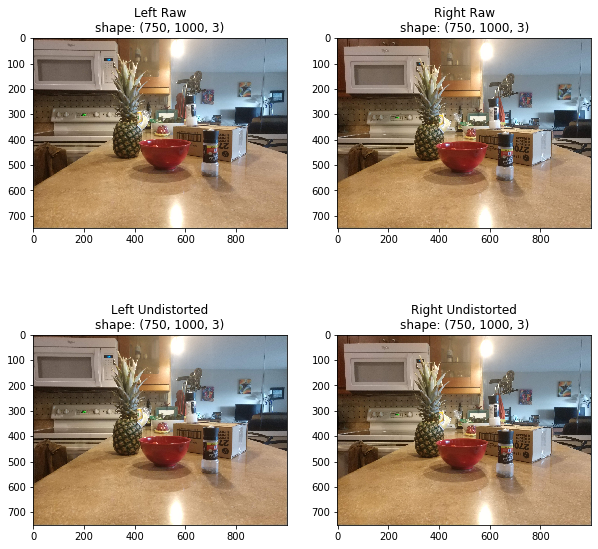

In [2]:
plt.rcParams["figure.figsize"] = [10,10]
# load images
image_scale = .25
image_left = cv2.imread("images/pineapple_left.jpg")
image_right = cv2.imread("images/pineapple_right.jpg")
image_left = cv2.resize(image_left,(0,0),fx=image_scale,fy=image_scale)
image_right = cv2.resize(image_right,(0,0),fx=image_scale,fy=image_scale)
plt.subplot(2,2,1)
plt.title(f"Left Raw\nshape: {image_left.shape}")
plt.imshow(image_left[:,:,::-1])
plt.subplot(2,2,2)
plt.title(f"Right Raw\nshape: {image_right.shape}")
plt.imshow(image_right[:,:,::-1])
#plt.show()

parameter_filename = f"camera_parameters_scale{image_scale:.4f}.json"
with open(parameter_filename,'r') as fp:
    parameters = json.load(fp)

mtx = np.array(parameters['mtx'],dtype=np.float32)
newCameraMtx = np.array(parameters['newCameraMtx'],dtype=np.float32)
dist = np.array(parameters['dist'],dtype=np.float32)
roi = np.array(parameters['roi'],dtype=np.int32)

def undistort(image, mtx, dist, newCameraMtx, roi):
    x,y,w,h = roi
    mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newCameraMtx,(w,h),5)
    dst = cv2.remap(image,mapx,mapy,cv2.INTER_LINEAR)
    dst = dst[y:y+h,x:x+w]
    return dst

#image_left = undistort(image_left, mtx, dist, newCameraMtx, roi)
#image_right = undistort(image_right, mtx, dist, newCameraMtx, roi)
plt.subplot(2,2,3)
plt.title(f"Left Undistorted\nshape: {image_left.shape}")
plt.imshow(image_left[:,:,::-1])
plt.subplot(2,2,4)
plt.title(f"Right Undistorted\nshape: {image_right.shape}")
plt.imshow(image_right[:,:,::-1])
plt.show()

Found 383 matches from 1000


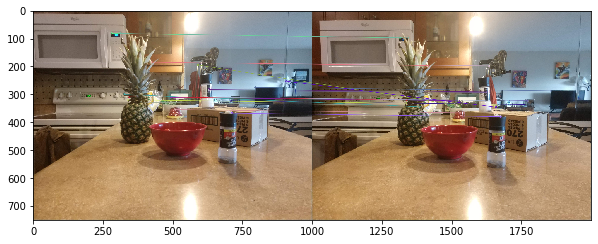

In [3]:
# Compute keypoints and descriptors
left_gray = cv2.cvtColor(image_left,cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(image_right,cv2.COLOR_BGR2GRAY)
orb = cv2.ORB_create(nfeatures=1000)
kps1, descs1 = orb.detectAndCompute(left_gray,None)
kps2, descs2 = orb.detectAndCompute(right_gray,None)

# Match descriptors
MIN_MATCH_COUNT = 10
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                  table_number =12, # 12
                  key_size = 10,     # 20
                  multi_probe_level = 2) #2
search_params = {"checks":100}
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descs1, descs2, k=2) # query is descs1 which is left image

good_matches = []
pts1 = []
pts2 = []
for i, (m,n) in enumerate(matches):
    if m.distance < 0.9*n.distance:
        good_matches.append(m)
        pts2.append(kps2[m.trainIdx].pt)
        pts1.append(kps1[m.queryIdx].pt)
print(f"Found {len(good_matches)} matches from {len(matches)}")   

img3 = cv2.drawMatches(image_left,kps1, image_right,kps2, good_matches[:20],None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3[:,:,::-1])
plt.show()

In [4]:
# Now find the fundamental Matrix
pts1 = np.array(pts1,dtype=np.int32)
pts2 = np.array(pts2,dtype=np.int32)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
# We select only inlier points
pts1_inliers = pts1[mask.ravel()==1]
pts2_inliers = pts2[mask.ravel()==1]
print(f"{pts1_inliers.shape[0]}/{len(good_matches)} points were found to be inliers")
print(f"Fundamental Matrix:\n{F}")

290/383 points were found to be inliers
Fundamental Matrix:
[[-1.44691632e-07 -1.00222108e-05  4.76199625e-03]
 [ 1.29300910e-05  1.58710846e-06 -3.65498275e-02]
 [-5.69385313e-03  3.39937498e-02  1.00000000e+00]]


In [5]:
# Now find the Essential Matrix
pts1 = np.array(pts1,dtype=np.int32)
pts2 = np.array(pts2,dtype=np.int32)
E, mask = cv2.findEssentialMat(pts1, pts2, mtx, cv2.FM_LMEDS)
# We select only inlier points
pts1_inliers = pts1[mask.ravel()==1]
pts2_inliers = pts2[mask.ravel()==1]
print(f"{pts1_inliers.shape[0]}/{len(good_matches)} points were found to be inliers")
print(f"Essential Matrix:\n{E}")

281/383 points were found to be inliers
Essential Matrix:
[[ 6.29176638e-04  1.37980739e-01  7.48352083e-03]
 [-3.50593593e-02  1.06351416e-02 -7.06135319e-01]
 [ 1.75436492e-03  6.93430944e-01  9.27423717e-03]]


In [6]:
# With the essential matrix of the camera pair, we can compute the pose of camera 2 relative to camera 1
retval, R, t, mask = cv2.recoverPose(E, pts1_inliers, pts2_inliers, mtx)
print(f"Rotation Matrix:\n{R}\n\nTranslation Matrix (is unit vector, scale unknown):\n{t}")

Rotation Matrix:
[[ 0.98917158 -0.01244173  0.14623541]
 [ 0.01042623  0.99983991  0.01454098]
 [-0.14639291 -0.01285884  0.98914294]]

Translation Matrix (is unit vector, scale unknown):
[[-0.98071904]
 [-0.00782893]
 [ 0.19526616]]


In [7]:
R1, R2, P1, P2, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(mtx,dist, mtx, dist, image_left.shape[:2], R,t)

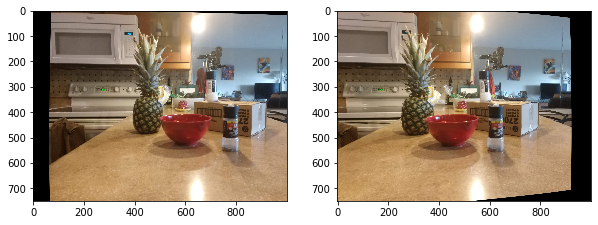

In [8]:
shape = (image_left.shape[1],image_left.shape[0])
mapx1,mapy1  = cv2.initUndistortRectifyMap(mtx, dist, R1, P1, shape, cv2.CV_32FC1)
mapx2,mapy2  = cv2.initUndistortRectifyMap(mtx, dist, R2, P2, shape, cv2.CV_32FC1)
image_left_rectified = cv2.remap(image_left,mapx1,mapy1,cv2.INTER_LINEAR)
image_right_rectified = cv2.remap(image_right,mapx2,mapy2,cv2.INTER_LINEAR)
plt.subplot(1,2,1)
plt.imshow(image_left_rectified[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(image_right_rectified[:,:,::-1])
plt.show()

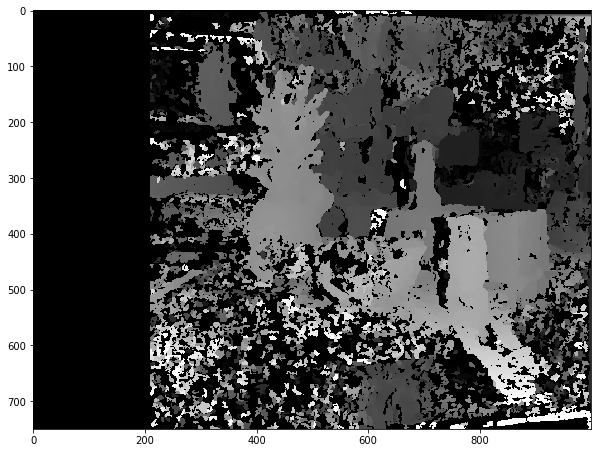

In [9]:

stereo = cv2.StereoSGBM_create(minDisparity=50,
                                numDisparities=10*16,
                                blockSize=13,
                                P1=0,
                                P2=0,
                                #disp12MaxDiff=0,
                                #preFilterCap=1,
                                uniquenessRatio=0,
                                speckleWindowSize=40,
                                speckleRange=7)

disparity = stereo.compute(cv2.cvtColor(image_left_rectified,cv2.COLOR_BGR2GRAY),
                           cv2.cvtColor(image_right_rectified,cv2.COLOR_BGR2GRAY)).astype(np.float32)/16
plt.imshow(disparity,cmap="gray")
plt.show()

[7 0]


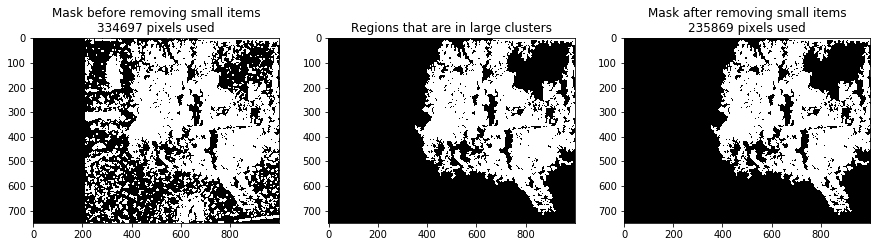

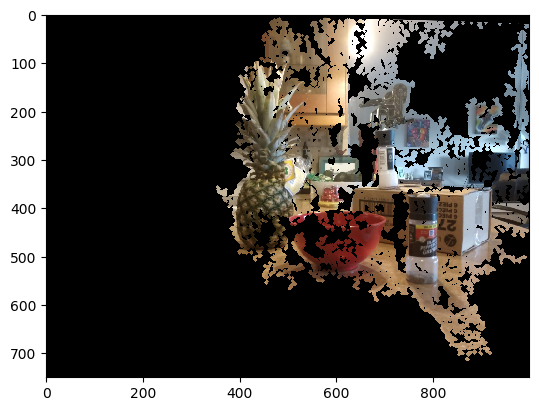

In [10]:
mask = disparity>disparity.min()
mask = mask.astype(np.uint8)

# combined goes to 318269

# Get rid of small items by themselves
# can help segment off regions connected by 1 pixel
mask = cv2.morphologyEx(mask,cv2.MORPH_OPEN,cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)),iterations =3)


# by itself goes from 384675 to 346905
# Idea here is to find small connected components in the mask and remove them.
# The simplest thing to do is just keep the top few percent of clusters
#    other options like keeping below a specific size are useful as well
#    It may also be interesting to filter out clusters that are skinny, oblong, or have a large bounding box
#       but do not have many pixels in them
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(mask,connectivity=8)
sizes = stats[1:,-1]
nb_components = nb_components - 1

cluster_idx_sorted = np.argsort(stats[:,-1])
num_clusters = cluster_idx_sorted.shape[0]
num_clusters_to_keep = max(int(num_clusters*.002),2) # always keep at least 1
clusters_to_keep = cluster_idx_sorted[-num_clusters_to_keep:]
print(clusters_to_keep)

cluster_mask = np.zeros_like(mask)
for cluster_id in clusters_to_keep:
    if cluster_id == 0: #cluster 0 is always the background
        continue
    cluster_mask[output == cluster_id] = 1
    

plt.rcParams['figure.figsize'] = [15,6]
plt.subplot(1,3,1)
plt.title(f"Mask before removing small items\n{np.sum(mask)} pixels used")
plt.imshow(mask,cmap="gray")

plt.subplot(1,3,2)
plt.title(f"Regions that are in large clusters")
plt.imshow(cluster_mask,cmap="gray")


mask = mask.astype(np.bool)
mask = np.logical_and(mask, cluster_mask)
l = np.zeros_like(image_left_rectified)
l[mask] = image_left_rectified[mask]

plt.subplot(1,3,3)
plt.title(f"Mask after removing small items\n{np.sum(mask)} pixels used")
plt.imshow(mask,cmap="gray")
plt.show()
plt.rcParams = plt.rcParamsDefault

plt.imshow(l[:,:,::-1])
plt.show()

In [11]:
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [12]:
# Reproject the verticies to 3d, get the colors correct as well
verticies = cv2.reprojectImageTo3D(disparity,Q)
colors = cv2.cvtColor(image_left_rectified,cv2.COLOR_BGR2RGB)

In [13]:
# This allows us to only export the values we are interested in, instead of a bunch of points at 0
mask_3d = np.repeat(np.expand_dims(mask,axis=-1),3,axis=-1)
mask_3d_inverted = np.logical_not(mask_3d) # masked arrays have mask==1 when not using value
verticies = np.ma.masked_array(verticies, mask=mask_3d_inverted).compressed()
colors = np.ma.masked_array(colors, mask=mask_3d_inverted).compressed()

write_ply(f"pointcloud_imagescale{image_scale:.4f}.ply",verticies,colors)